In [12]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

import sys
sys.path.insert(0,"../../project_1/src/")
sys.path.insert(0,"../src/")

import NeuralNetwork as NN
from CostFunctions import *
from ActivationFunctions import *

import utils
from stat_tools import *

from imageio import imread

# Quick and easy way to get rid of sci-kit learns warning messages when
# doing gradient descent.
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


utils.plot_settings()  # LaTeX fonts in Plots!

FIGPATH = "../figs/"
FIGURESIZE= np.array([4,3]) # Good default figure size for tex documents

SEEDVAL = 2020

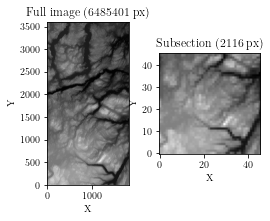

In [7]:
# Setting up the terrain data:
# Note structure! X-coordinates are on the rows of terrain_data
# Point_selection.flatten() moves most rapidly over the x-coordinates
# Meshgrids flattened also move most rapidly over the x-coordinates. Thus
# this should make z(x,y).reshape(length_y,length_x) be consistent with terrain_data

np.random.seed(SEEDVAL)
terrain_data = imread("../../project_1/datafiles/SRTM_data_Norway_1.tif")
point_selection = terrain_data[:1801:40, :1801:40]  # Make quadratic and downsample
x_terrain_selection = np.linspace(0, 1, point_selection.shape[1])
y_terrain_selection = np.linspace(0, 1, point_selection.shape[0])
X_coord_selection, Y_coord_selection = np.meshgrid(x_terrain_selection, y_terrain_selection)
z_terrain_selection = point_selection.flatten()  # the response values
x_terrain_selection_flat = X_coord_selection.flatten()  # the first degree feature variables
y_terrain_selection_flat = Y_coord_selection.flatten()  # the first degree feature variables

x = x_terrain_selection_flat
y = y_terrain_selection_flat
z = z_terrain_selection


x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

xy_train = np.array([x_train, y_train]).T
xy_test = np.array([x_test, y_test]).T

# Centering
z_intercept = np.mean(z)
z = z - z_intercept

z_train_intercept = np.mean(z_train)
z_train = z_train - z_train_intercept
z_test = z_test - z_train_intercept

z_train = z_train.reshape(-1, 1)
z_test = z_test.reshape(-1, 1)

# Show the terrain
plt.figure(figsize=FIGURESIZE)
plt.subplot(121)
plt.title(f"Full image ({terrain_data.size} px)")
plt.imshow(terrain_data, cmap="gray", origin="lower")
plt.xlabel("X")
plt.ylabel("Y")
plt.subplot(122)
plt.imshow(point_selection, cmap="gray", origin="lower")
plt.title(f"Subsection ({point_selection.size} px)")
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig(FIGPATH+"TerrainData.pdf")
plt.show()

In [17]:
N = xy_train.shape[0]

per_loop = 1
tot_epochs = 100
num_loops = int(tot_epochs / per_loop)

NN_MSE = np.empty(num_loops)
NN_epochs = np.empty(num_loops)

FFNN = NN.FeedForwardNeuralNetwork(
        X = xy_train,
        Y = z_train,
        network_shape = [100, 100, 100],
        activation = Sigmoid,
        activation_out = ID,
        #momentum = 0.0001,
        #lambd = 1e-4,
        init_weights_method = "xavier",
        learning_rate_decay="inverse"
)

Initializing weights using: Xavier


In [105]:
w1 = FFNN.weights
b1 = FFNN.biases

In [111]:
np.save("../../../sig_w.np", w1)
np.save("../../../sig_b.np", b1)

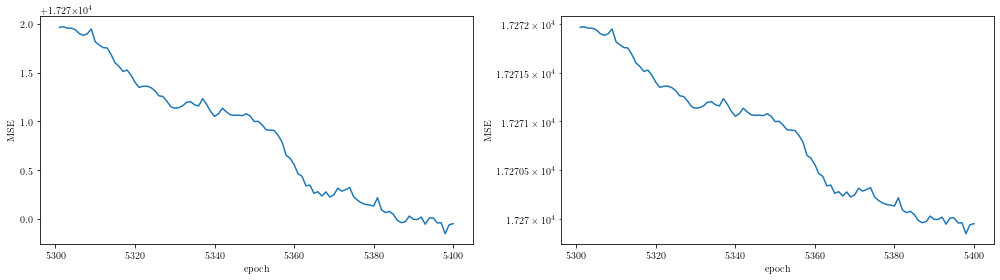

17269.95244649609


In [106]:
w = FFNN.weights
b = FFNN.biases

for i in range(num_loops):
    FFNN.train(N_minibatches=int(N/32), learning_rate=0.0000001, n_epochs=1, decay_rate=0)
    NN_MSE[i] = MSE(z_test, FFNN.predict(xy_test))
    NN_epochs[i] = FFNN.total_epochs

plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.plot(NN_epochs, NN_MSE)
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.subplot(122)
plt.semilogy(NN_epochs, NN_MSE)
plt.xlabel("epoch")
plt.ylabel("MSE")

plt.tight_layout()
plt.show()

print(NN_MSE[-1])

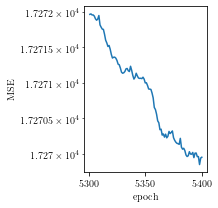

In [120]:
plt.figure(figsize=(5, 3))
plt.subplot(121)
plt.semilogy(NN_epochs, NN_MSE)
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.tight_layout()
plt.savefig(FIGPATH+"sigmoid_MSE.pdf")
plt.show()

In [107]:
spacing = 40 # Try 100, and try 40

np.random.seed(SEEDVAL)
# Setting up the terrain data:
# Note structure! X-coordinates are on the rows of terrain_data
# Point_selection.flatten() moves most rapidly over the x-coordinates
# Meshgrids flattened also move most rapidly over the x-coordinates. Thus
# this should make z(x,y).reshape(length_y,length_x) be consistent with terrain_data
terrain_data = imread("../../project_1/datafiles/SRTM_data_Norway_1.tif")
point_selection = terrain_data[:1801:spacing, :1801:spacing]  # Make quadratic and downsample
x_terrain_selection = np.linspace(0, 1, point_selection.shape[1])
y_terrain_selection = np.linspace(0, 1, point_selection.shape[0])
X_coord_selection, Y_coord_selection = np.meshgrid(x_terrain_selection, y_terrain_selection)
z_terrain_selection = point_selection.flatten()  # the response values
x_terrain_selection_flat = X_coord_selection.flatten()  # the first degree feature variables
y_terrain_selection_flat = Y_coord_selection.flatten()  # the first degree feature variables

x = x_terrain_selection_flat
y = y_terrain_selection_flat
z = z_terrain_selection

xy = np.array([x, y]).T

x_plot = np.linspace(0, 1, 1801)
y_plot = np.linspace(0, 1, 1801)
x_plot_mesh, y_plot_mesh = np.meshgrid(x_plot, y_plot)
x_plot_mesh_flat, y_plot_mesh_flat = x_plot_mesh.flatten(), y_plot_mesh.flatten()

# Ground truth

z_true = terrain_data[:1801, :1801]



z_prediction = FFNN.predict(np.array([x_plot_mesh_flat, y_plot_mesh_flat]).T)
z_prediction += z_intercept

"""
# OLS
betas = linear_regression.OLS_SVD_2D(X_scaled, z)
z_predict_flat_ols = (X_plot_design_scaled @ betas) + z_intercept
z_predict_ols = z_predict_flat_ols.reshape(-1, 1801)
"""

z_pred_plot = z_prediction.reshape(x_plot_mesh.shape)

In [40]:
print(z_prediction.shape)
print(x_plot_mesh.shape)

z_pred_plot = z_prediction.reshape(x_plot_mesh.shape)

(3243601, 1)
(1801, 1801)


In [108]:
FFNN.a

array([array([[4.74217163e-01, 6.95106514e-02, 2.42747894e-01, ...,
        9.71631078e-04, 6.96784766e-04, 3.14735682e-01],
       [7.14259790e-02, 6.76839000e-01, 6.74890998e-02, ...,
        3.64182776e-02, 2.07406228e-02, 1.01641900e-01],
       [6.14554481e-02, 9.87807671e-01, 6.56620188e-02, ...,
        5.54862222e-02, 4.63214260e-03, 8.49549671e-02],
       ...,
       [3.59872074e-01, 9.42624990e-01, 2.09245230e-01, ...,
        2.58883489e-03, 1.21297788e-04, 2.32579862e-01],
       [5.09651552e-03, 9.57657992e-01, 1.35308357e-02, ...,
        6.62955316e-01, 6.35041828e-01, 2.45752686e-02],
       [1.33989329e-01, 7.85295356e-01, 1.02136961e-01, ...,
        1.43950795e-02, 3.74177457e-03, 1.38500769e-01]]),
       array([[9.98668509e-01, 2.08898725e-20, 4.56991174e-02, ...,
        6.36058234e-13, 1.67697801e-01, 5.25499163e-01],
       [2.30081076e-11, 4.29090203e-09, 6.78968605e-01, ...,
        8.04099449e-05, 9.99211403e-01, 1.82914608e-05],
       [3.30633445e-15, 1.14

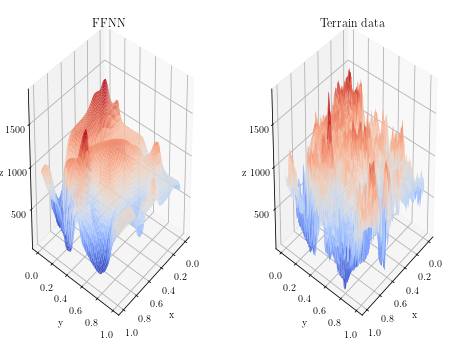

In [109]:
fig = plt.figure(figsize=2*FIGURESIZE)

azim=40
elev=30

# Plot the OLS prediction
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.set_title("FFNN")
ax.view_init(azim=azim, elev=elev)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([np.amin(z_true), np.amax(z_true)])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_pred_plot,cmap=cm.coolwarm, rasterized=True)

# Plot the true terrain data
ax = fig.add_subplot(1, 2, 2, projection="3d")
ax.set_title("Terrain data")
ax.view_init(azim=azim, elev=elev)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([np.amin(z_true), np.amax(z_true)])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_true, cmap=cm.coolwarm, rasterized=True)

plt.savefig(FIGPATH+"TERRAIN_FIT_3D_sigmoid.pdf")

plt.show()


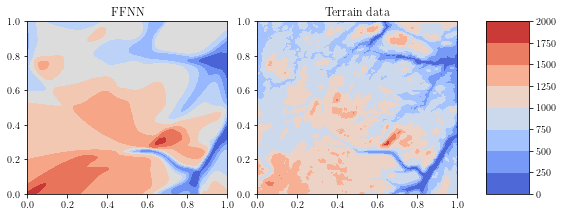

In [110]:
plt.figure(figsize=np.array([2, 1])*FIGURESIZE)
plt.subplot(121)
plt.contourf(x_plot_mesh, y_plot_mesh, z_pred_plot, cmap=cm.coolwarm)
plt.title("FFNN")
plt.tight_layout()

plt.subplot(122)
plt.contourf(x_plot_mesh, y_plot_mesh, z_true, cmap=cm.coolwarm)
plt.title("Terrain data")
plt.tight_layout()


plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

plt.savefig(FIGPATH+"TERRAIN_FIT_CONTOUR_sigmoid.pdf")